### DOPP Group 3, Poj Netsiri (12402153), Zita Dorina Marton (12340246), Daniel Werner (12429667), Nikita Sidorov (62106043), Abhinandan Singh (12402163)

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import geodatasets
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

from scipy import stats
from itertools import combinations
from matplotlib.cm import get_cmap
from itertools import combinations
from IPython.display import display
from scipy.stats import pearsonr, spearmanr


warnings.filterwarnings('ignore')

### Global settings


In [3]:
# Role of company size settings
UNIT = "PC_ETURN"
INDIC = "E_AWSVAL"
SIZE_PRIMARY = "GE10"
SIZE_COMPARE = "GE250"
PREFERRED_ORDER = ["GE10", "10-49", "50-249", "10-249", "GE250"]
REQUIRED_COLS = {"year", "value", "size_emp", "indic_is", "unit", "geo"}

PREFERRED = [
    ("E_AWSELL", "PC_ENT_AWSELL"),  # % enterprises with web sales
    ("E_AESELL", "PC_ENT_AESELL"),  # % enterprises with e-commerce sales
]

FALLBACK = [
    ("E_AWSVAL", "PC_ETURN"),       # % of turnover from web/e-commerce sales
    ("E_ETURN",  "PC_ETURN"),       # if dataset uses E_ETURN with PC_ETURN
]

#Adoption analysis settings
COMP_SIZE = "10-49"
TOP_K = 10
YEAR_SNAPSHOT = 2024
START_GROWTH_YEAR = 2018

#visualization settings
cmap_name = "tab10"
sns.set_palette("husl")
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

EU_ISO2 = ["AT","BE","BG","CY","CZ","DE","DK","EE","EL","ES",
           "FI","FR","HR","HU","IE","IT","LT","LU","LV","MT",
           "NL","PL","PT","RO","SE","SI","SK"]
world = gpd.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
).rename(columns={"ISO3166-1-Alpha-2": "geo"})

### Load all 4 datasets

In [6]:
dfs = []

for path in ["evals.csv", "evaln2.csv", "esels.csv", "eseln2.csv"]:
    tmp = pd.read_csv(path)
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
df.columns = df.columns.str.strip()

for c in ["geo", "size_emp", "indic_is", "unit"]:
    df[c] = df[c].astype(str).str.strip()

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df = df[df["geo"].isin(EU_ISO2)].copy()

df = df.dropna(subset=sorted(REQUIRED_COLS)).copy()
df["year"] = df["year"].round().astype(int)

print("Loaded rows:", len(df))
print("Columns:", list(df.columns))
print("Size classes (sample):", sorted(df["size_emp"].unique())[:15])
print("Indicators (sample):", sorted(df["indic_is"].unique())[:10])
print("Units (sample):", sorted(df["unit"].unique())[:10])

Loaded rows: 110616
Columns: ['geo', 'geo_name', 'size_emp', 'size_label', 'indic_is', 'indic_label', 'unit', 'unit_label', 'year', 'value', 'nace_r2', 'nace_label']
Size classes (sample): ['10-249', '10-49', '50-249', 'GE10', 'GE250', 'nan']
Indicators (sample): ['E_AESELL', 'E_AWSELL', 'E_AWSVAL', 'E_AWSVAL_B2BG', 'E_AWSVAL_B2C', 'E_AWSVAL_B2C_GE10WS', 'E_AWS_B2BG', 'E_AWS_B2C', 'E_AWS_B2C_GT1WS', 'E_AWS_GT1_B2C_GT10WS']
Units (sample): ['PC_AWSVAL', 'PC_ENT', 'PC_ENT_AESELL', 'PC_ENT_AWSELL', 'PC_ENT_IUSE', 'PC_ETURN', 'PC_TURN']


### 1. Company size analysis

In [7]:
def pick_series(df_: pd.DataFrame):
    available = set(zip(df_["indic_is"].astype(str), df_["unit"].astype(str)))
    for ind, unit in PREFERRED:
        if (ind, unit) in available:
            return ind, unit, "adoption_enterprises"
    for ind, unit in FALLBACK:
        if (ind, unit) in available:
            return ind, unit, "turnover_share_proxy"

INDIC, UNIT, MEASURE_KIND = pick_series(df)
d = df[(df["indic_is"] == INDIC) & (df["unit"] == UNIT)].copy()

print(f"Using INDIC={INDIC}, UNIT={UNIT} ({MEASURE_KIND})")

Using INDIC=E_AWSVAL, UNIT=PC_ETURN (turnover_share_proxy)


###  EU-average year over year by company size

In [8]:
country_size_year = (
    d.groupby(["geo", "size_emp", "year"], as_index=False)["value"]
     .mean()
     .rename(columns={"value": "adoption"})
)

size_year = (
    country_size_year.groupby(["size_emp", "year"], as_index=False)["adoption"]
     .mean()
     .sort_values(["size_emp", "year"])
)

latest_year = int(size_year["year"].max())
start_year = int(size_year["year"].min())

# YoY growth per size
size_year["yoy_growth"] = (
    size_year.groupby("size_emp")["adoption"]
    .pct_change() * 100
)

# CAGR summary from the earliest year
wide = size_year.pivot(index="year", columns="size_emp", values="adoption").sort_index()
base_year = 2015 if 2015 in wide.index else int(wide.index.min())
end_year = int(wide.index.max())
start_vals = wide.loc[base_year]
end_vals = wide.loc[end_year]

summary = pd.DataFrame({
    "size_emp": wide.columns.astype(str),
    "start_val": start_vals.values,
    "end_val": end_vals.values
}).dropna(subset=["start_val", "end_val"])

summary = summary[summary["start_val"] > 0].copy()
period_years = max(1, int(end_year - base_year))
summary["cagr"] = ((summary["end_val"] / summary["start_val"]) ** (1 / period_years) - 1) * 100

avg_yoy = (
    size_year.dropna(subset=["yoy_growth"])
    .groupby("size_emp", as_index=False)["yoy_growth"]
    .mean()
    .rename(columns={"yoy_growth": "avg_yoy_growth"})
)

summary = summary.merge(avg_yoy, on="size_emp", how="left")
summary = summary.sort_values("end_val", ascending=False).reset_index(drop=True)

print("\nEU (unweighted country-average) by company size:")
display(summary)


EU (unweighted country-average) by company size:


,size_emp,start_val,end_val,cagr,avg_yoy_growth
0,10-49,56.739130,68.081429,2.045533,1.644947
1,nan,60.332065,63.980750,0.654561,0.326561
2,10-249,49.320682,57.722857,1.763251,2.014392
3,50-249,44.682391,50.486190,1.366140,1.892610
4,GE10,36.423478,46.968571,2.865454,2.032970
5,GE250,30.218696,42.513636,3.865784,2.387900


### How has e-commerce evolved over time for each company size? - Heatmap

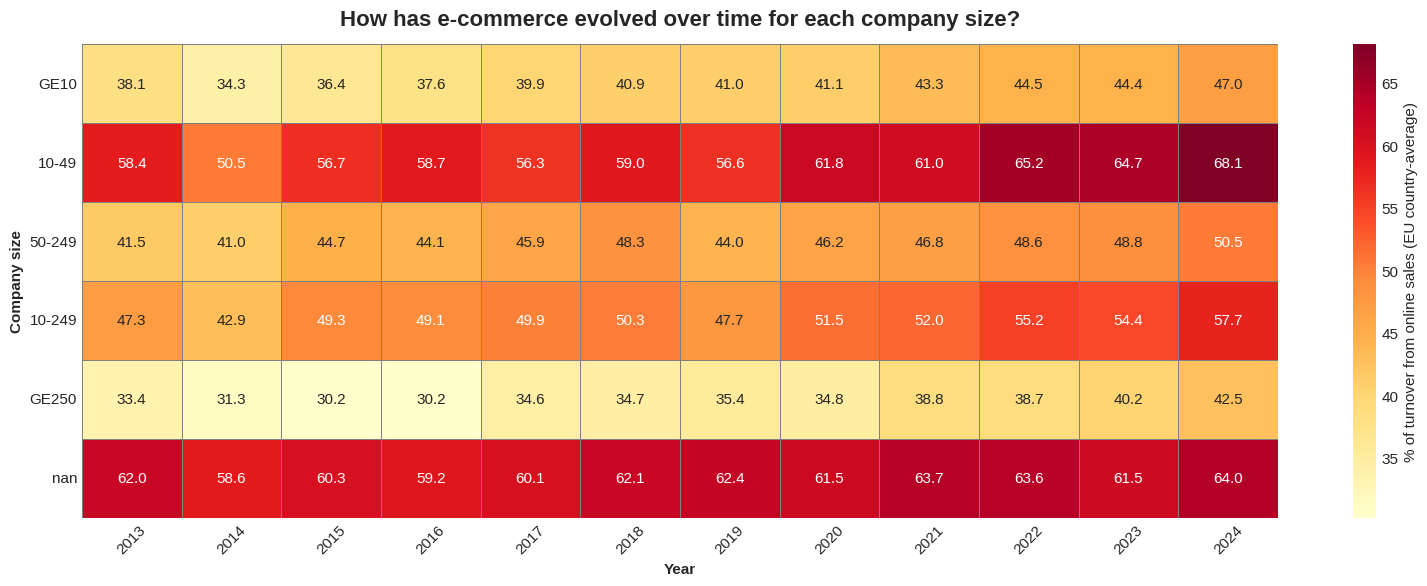

In [9]:
sizes_present = [s for s in PREFERRED_ORDER if s in size_year["size_emp"].unique()]
other_sizes = sorted(set(size_year["size_emp"].unique()) - set(sizes_present))
size_order = sizes_present + other_sizes

pivot_size_year = (
    size_year.pivot(index="size_emp", columns="year", values="adoption")
    .reindex(index=size_order)
    .sort_index(axis=1)
)

plt.figure(figsize=(16, 6))

title_metric = (
    "% of enterprises with online sales"
    if MEASURE_KIND == "adoption_enterprises"
    else "% of turnover from online sales"
)

sns.heatmap(
    pivot_size_year,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": f"{title_metric} (EU country-average)"} # — INDIC={INDIC}, UNIT={UNIT}"}
)

plt.title(
    "How has e-commerce evolved over time for each company size?",
    fontsize=16,
    fontweight="bold",
    pad=14
)
plt.xlabel("Year", fontsize=11, fontweight="bold")
plt.ylabel("Company size", fontsize=11, fontweight="bold")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### Which company size relies more on e-commerce right now? (2024) - Radial bar chart

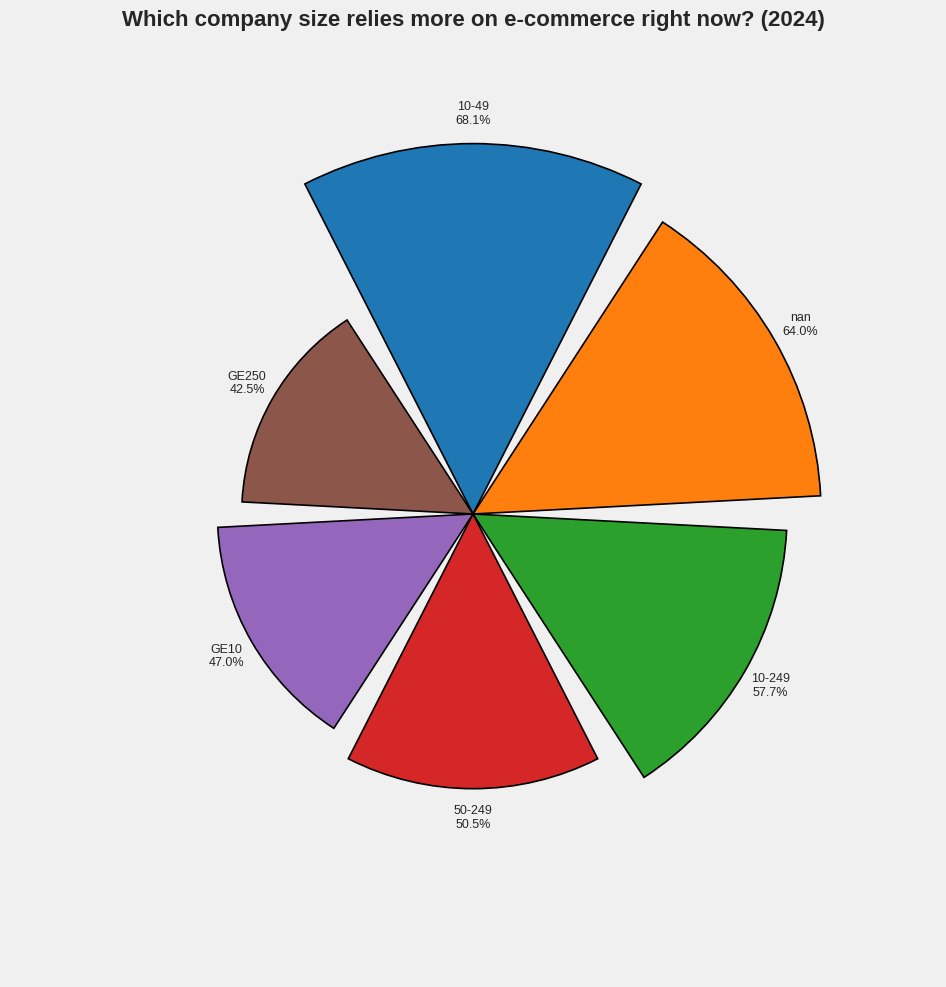

In [10]:
latest_tbl = (
    size_year[size_year["year"] == latest_year]
    .dropna(subset=["adoption"])
    .copy()
)

latest_tbl = (
    latest_tbl
    .sort_values("adoption", ascending=False)
    .reset_index(drop=True)
)

labels = latest_tbl["size_emp"].astype(str).to_list()
values = latest_tbl["adoption"].to_numpy(dtype=float)

N = len(values)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
width = (2 * np.pi / N) * 0.90 if N > 0 else 0.0

cmap = mpl.colormaps.get_cmap("tab10" if N <= 10 else "tab20")
colors = [cmap(i % cmap.N) for i in range(N)]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

fig.patch.set_facecolor("#f0f0f0")
ax.set_facecolor("#f0f0f0")

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.spines["polar"].set_visible(False)
ax.grid(False)

ax.bar(theta, values, width=width, color=colors, edgecolor="black", linewidth=1.2)

rmax_val = float(np.nanmax(values)) if len(values) and np.isfinite(np.nanmax(values)) else 1.0
rmax = rmax_val if rmax_val > 0 else 1.0

for t, v, lbl in zip(theta, values, labels):
    ax.text(
        t,
        v + rmax * 0.08,
        f"{lbl}\n{v:.1f}%",
        ha="center",
        va="center",
        fontsize=9
    )

ax.set_title(
    "Which company size relies more on e-commerce right now? (2024)",
    pad=18, fontsize=16, fontweight="bold",
)

ax.set_ylim(0, rmax * 1.25)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


### STATISTICAL SUMMARY

In [11]:
summary_tbl = (
    latest_tbl[["size_emp", "adoption"]]
    .rename(columns={"size_emp": "Company size", "adoption": "Online commerce (%)"})
    .reset_index(drop=True)
)

stats = {
    "Mean (%)": summary_tbl["Online commerce (%)"].mean(),
    "Median (%)": summary_tbl["Online commerce (%)"].median(),
    "Min (%)": summary_tbl["Online commerce (%)"].min(),
    "Max (%)": summary_tbl["Online commerce (%)"].max(),
    "Std Dev (%)": summary_tbl["Online commerce (%)"].std(),
}

stats_tbl = pd.DataFrame.from_dict(stats, orient="index", columns=["Value"]).round(2)

print("=" * 70)
print("STATISTICAL SUMMARY — ROLE OF COMPANY SIZE IN ONLINE COMMERCE")
print("=" * 70)
print()
print("EU country-average by company size (latest year):")
display(summary_tbl)

print("\nDescriptive statistics:")
display(stats_tbl)
diff_tbl = summary_tbl.copy()
diff_tbl["Δ vs previous size (pp)"] = diff_tbl["Online commerce (%)"].diff()

print("\nSize gradient (percentage-point change vs previous size):")
display(diff_tbl.round(2))

STATISTICAL SUMMARY — ROLE OF COMPANY SIZE IN ONLINE COMMERCE

EU country-average by company size (latest year):


,Company size,Online commerce (%)
0,10-49,68.081429
1,nan,63.980750
2,10-249,57.722857
3,50-249,50.486190
4,GE10,46.968571
5,GE250,42.513636



Descriptive statistics:


,Value
Mean (%),54.96
Median (%),54.10
Min (%),42.51
Max (%),68.08
Std Dev (%),10.00



Size gradient (percentage-point change vs previous size):


,Company size,Online commerce (%),Δ vs previous size (pp)
0,10-49,68.08,NaN
1,nan,63.98,-4.10
2,10-249,57.72,-6.26
3,50-249,50.49,-7.24
4,GE10,46.97,-3.52
5,GE250,42.51,-4.45


### Correlation analysis - scatter plot

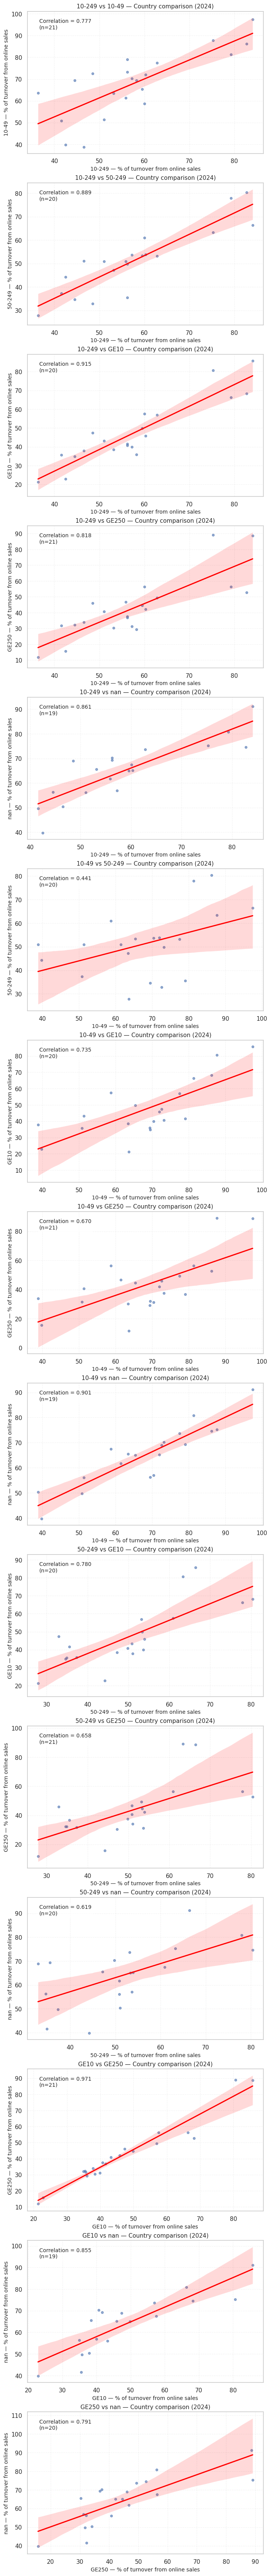

In [12]:
latest_country = country_size_year[country_size_year["year"] == latest_year].copy()
wide_country_all = latest_country.pivot(index="geo", columns="size_emp", values="adoption")
valid_sizes = wide_country_all.columns.tolist()
wide_country_all = wide_country_all[valid_sizes]
pairs = list(combinations(valid_sizes, 2))

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=len(pairs),
    ncols=1,
    figsize=(7, 4.5 * len(pairs)),
    constrained_layout=True
)


for ax, (s1, s2) in zip(axes, pairs):

    pair_df = wide_country_all[[s1, s2]].dropna()
    corr = pair_df[s1].corr(pair_df[s2])

    sns.regplot(
        data=pair_df.reset_index(),
        x=s1,
        y=s2,
        ax=ax,
        scatter_kws={"alpha": 0.6, "s": 18},
        line_kws={"color": "red"}
    )

    ax.set_xlabel(f"{s1} — {title_metric}", fontsize=10)
    ax.set_ylabel(f"{s2} — {title_metric}", fontsize=10)
    ax.set_title(f"{s1} vs {s2} — Country comparison ({latest_year})", fontsize=11)

    ax.grid(True, alpha=0.25, linewidth=0.8, linestyle="--")

    ax.text(
        0.05, 0.95,
        f"Correlation = {corr:.3f}\n(n={len(pair_df)})",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.75)
    )

plt.show()

### Q1: What role does company size play in e-commerce adoption?

#### Company size has a clear impact on how much firms rely on e-commerce across the EU. In 2024, smaller companies depend most on online sales: firms with 10–49 employees generate roughly two-thirds of their turnover online, while medium-sized firms generate about half, and large firms less than half. Although e-commerce usage has grown for all company sizes, smaller firms have increased their online activity the most. This makes business sense—smaller firms often use e-commerce as a primary route to reach customers beyond their local markets, whereas larger firms typically combine online sales with strong offline channels. Countries with higher digital maturity show stronger e-commerce adoption overall, but in every country smaller firms remain more reliant on online sales than larger ones.

### 2. Adoption analysis

In [13]:
# Create a new dataframe for this analysi
df_long = df[
    (df["unit"] == UNIT) &
    (df["indic_is"] == INDIC) &
    (df["size_emp"] == COMP_SIZE) &
    (df["geo"].isin(EU_ISO2))
].copy()

df_long = df_long.drop(columns=["nace_r2", "nace_label"], errors="ignore")

df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")

display(df_long)


,geo,geo_name,size_emp,size_label,indic_is,indic_label,unit,unit_label,year,value
528,AT,Austria,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2013,30.91
529,AT,Austria,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2014,24.33
530,AT,Austria,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2015,35.52
531,AT,Austria,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2016,64.19
532,AT,Austria,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2017,64.73
...,...,...,...,...,...,...,...,...,...,...
17695,SK,Slovakia,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2020,67.97
17696,SK,Slovakia,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2021,45.62
17697,SK,Slovakia,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2022,67.67
17698,SK,Slovakia,10-49,Small (10–49),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2023,64.02


### Group data by country and year

In [14]:
country_year = (
    df_long
    .groupby(["geo", "year"], as_index=False)["value"]
    .sum()
    .rename(columns={"value": "eturn_value"})
).sort_values(["geo", "year"])

country_year["eturn_yoy_growth"] = (
    country_year.groupby("geo")["eturn_value"].pct_change() * 100
)

first_non_null = (
    country_year
    .groupby("geo")["eturn_value"]
    .transform(lambda x: x.dropna().iloc[0] if x.dropna().size > 0 else np.nan)
)

country_year["eturn_growth_from_start"] = (
    (country_year["eturn_value"] - first_non_null) / first_non_null * 100
)

latest_year = int(country_year["year"].max())

growth_map_df = (
    country_year[country_year["year"] == latest_year]
    .loc[:, ["geo", "eturn_growth_from_start"]]
    .rename(columns={"eturn_growth_from_start": "growth"})
    .dropna(subset=["growth"])
)

growth_map_df["growth"] = growth_map_df["growth"].clip(lower=0, upper=200)
growth_map_df = growth_map_df.sort_values("growth", ascending=False).reset_index(drop=True)
growth_map_df = growth_map_df[growth_map_df["growth"] > 0]

### Statistical Summary

In [15]:
def pct(x, nd=2):
    return f"{x:.{nd}f}%"

def pp(x, nd=2):
    return f"{x:.{nd}f} percentage points"

country_year["year"] = pd.to_numeric(country_year["year"], errors="coerce")
country_year["eturn_value"] = pd.to_numeric(country_year["eturn_value"], errors="coerce")

snap_2024 = (
    country_year.loc[country_year["year"] == YEAR_SNAPSHOT]
    .dropna(subset=["eturn_value"])
    .copy()
)

snap_2024_geo = (
    snap_2024.groupby("geo", as_index=False)["eturn_value"]
    .mean()
)

snap_2024_geo["eturn_value"] = snap_2024_geo["eturn_value"].clip(lower=0, upper=100)

snap_mean = snap_2024_geo["eturn_value"].mean(skipna=True)
snap_median = snap_2024_geo["eturn_value"].median(skipna=True)
snap_std = snap_2024_geo["eturn_value"].std(skipna=True)

early_period = (start_year, min(start_year + 3, end_year))
recent_period = (max(YEAR_SNAPSHOT - 4, start_year), YEAR_SNAPSHOT)

early_avg = country_year.loc[
    country_year["year"].between(early_period[0], early_period[1]),
    "eturn_value"
].mean(skipna=True)

recent_avg = country_year.loc[
    country_year["year"].between(recent_period[0], recent_period[1]),
    "eturn_value"
].mean(skipna=True)

increase_pp = recent_avg - early_avg
growth_pct = (increase_pp / early_avg) * 100 if pd.notna(early_avg) and early_avg != 0 else np.nan

top5 = snap_2024_geo.sort_values("eturn_value", ascending=False).head(5)
bottom5 = snap_2024_geo.sort_values("eturn_value", ascending=True).head(5)

geo_to_name = df_long[["geo", "geo_name"]].drop_duplicates().set_index("geo")["geo_name"].to_dict()



def name_or_geo(g):
    if g == "EL":
        return "Greece"
    return geo_to_name.get(g, g)

growth_from_year = max(YEAR_SNAPSHOT - 6, start_year)

start_vals = (
    country_year[country_year["year"] == growth_from_year][["geo", "eturn_value"]]
    .rename(columns={"eturn_value": "start_val"})
)

end_vals = (
    country_year[country_year["year"] == YEAR_SNAPSHOT][["geo", "eturn_value"]]
    .rename(columns={"eturn_value": "end_val"})
)

grow_tbl = start_vals.merge(end_vals, on="geo", how="inner").dropna(subset=["start_val", "end_val"]).copy()
grow_tbl = grow_tbl[grow_tbl["start_val"] > 0]

years_n = YEAR_SNAPSHOT - growth_from_year
grow_tbl["avg_annual_growth_pct"] = (((grow_tbl["end_val"] / grow_tbl["start_val"]) ** (1/years_n)) - 1) * 100

fastest5 = grow_tbl.sort_values("avg_annual_growth_pct", ascending=False).head(5)


print("="*80)
print(f"STATISTICAL SUMMARY: E-COMMERCE (TURNOVER SHARE) — {COMP_SIZE}")
print("="*80)
print()
print(f"1. 2024 SNAPSHOT ({YEAR_SNAPSHOT}):")
print(f"   • Average e-commerce % of turnover: {pct(snap_mean, 2)}")
print(f"   • Median: {pct(snap_median, 2)}")
print(f"   • Std Dev: {pct(snap_std, 2)}")
print()
print("2. PERIOD COMPARISON (levels):")
print(f"   • Early period ({early_period[0]}-{early_period[1]}) avg: {pct(early_avg, 2)}")
print(f"   • Recent period ({recent_period[0]}-{recent_period[1]}) avg: {pct(recent_avg, 2)}")
print(f"   • Overall increase: {pp(increase_pp, 2)} ({pct(growth_pct, 1)} growth)")
print()
print(f"3. LEADERS AND LAGGARDS ({YEAR_SNAPSHOT}):")
print("   Top 5 Countries:")
for _, r in top5.iterrows():
    print(f"   • {name_or_geo(r['geo'])}: {pct(r['eturn_value'], 2)}")
print()
print("   Bottom 5 Countries:")
for _, r in bottom5.iterrows():
    print(f"   • {name_or_geo(r['geo'])}: {pct(r['eturn_value'], 2)}")
print()
print(f"4. FASTEST GROWING COUNTRIES ({growth_from_year}-{YEAR_SNAPSHOT}):")
rank = 1
for _, r in fastest5.iterrows():
    print(f"   {rank}. {name_or_geo(r['geo'])}: {r['avg_annual_growth_pct']:.1f}% avg annual growth")
    rank += 1


STATISTICAL SUMMARY: E-COMMERCE (TURNOVER SHARE) — 10-49

1. 2024 SNAPSHOT (2024):
   • Average e-commerce % of turnover: 68.08%
   • Median: 69.41%
   • Std Dev: 14.91%

2. PERIOD COMPARISON (levels):
   • Early period (2013-2016) avg: 56.08%
   • Recent period (2020-2024) avg: 64.09%
   • Overall increase: 8.01 percentage points (14.3% growth)

3. LEADERS AND LAGGARDS (2024):
   Top 5 Countries:
   • Greece: 97.46%
   • Cyprus: 87.70%
   • Bulgaria: 86.26%
   • Lithuania: 81.36%
   • Hungary: 79.09%

   Bottom 5 Countries:
   • Belgium: 38.82%
   • Denmark: 39.80%
   • Portugal: 50.87%
   • Sweden: 51.36%
   • Ireland: 58.78%

4. FASTEST GROWING COUNTRIES (2018-2024):
   1. Ireland: 19.5% avg annual growth
   2. Cyprus: 7.8% avg annual growth
   3. Czechia: 6.9% avg annual growth
   4. Latvia: 5.1% avg annual growth
   5. Croatia: 4.5% avg annual growth


### Top 10 countries by e-commerece turnover share - barchart

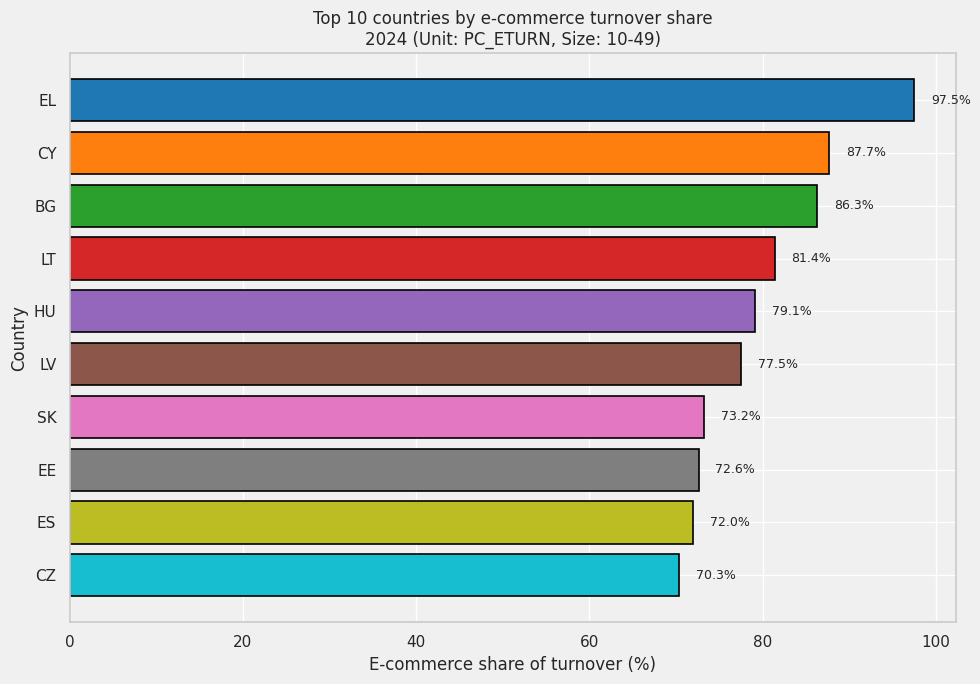

In [16]:
# 1) Build latest-year level table (one value per country)
lvl_tbl = (
    country_year.loc[country_year["year"] == latest_year, ["geo", "eturn_value"]]
    .dropna(subset=["eturn_value"])
    .groupby("geo", as_index=False)["eturn_value"]
    .mean()  # if multiple records per geo in the year, keep a single value
)

lvl_tbl["eturn_value"] = lvl_tbl["eturn_value"].clip(lower=0, upper=100)

# 2) Take Top 10 countries by turnover share
df_top_lvl = (
    lvl_tbl.sort_values("eturn_value", ascending=False)
    .head(TOP_K)
    .reset_index(drop=True)
)

top_countries = df_top_lvl["geo"].tolist()

# 3) Create a consistent color map (same approach as your reference)
cmap = get_cmap(cmap_name)
country_colors = {c: cmap(i % cmap.N) for i, c in enumerate(top_countries)}

# 4) Plot horizontal bar chart (match uploaded style)
bar = df_top_lvl.sort_values("eturn_value", ascending=True).copy()
colors_bar = [country_colors.get(c, "#333333") for c in bar["geo"]]

plt.figure(figsize=(10, 7))
ax = plt.gca()

plt.gcf().patch.set_facecolor("#f0f0f0")
ax.set_facecolor("#f0f0f0")
ax.grid(True, color="white", linewidth=1.0)
ax.set_axisbelow(True)


ax.barh(
    bar["geo"],
    bar["eturn_value"],
    color=colors_bar,
    edgecolor="black",
    linewidth=1.2
)

ax.set_title(
    f"Top {TOP_K} countries by e-commerce turnover share\n{latest_year} (Unit: {UNIT}, Size: {COMP_SIZE})"
)
ax.set_xlabel("E-commerce share of turnover (%)")
ax.set_ylabel("Country")

x_offset = bar["eturn_value"].max() * 0.02 if bar["eturn_value"].max() > 0 else 0.5
for i, v in enumerate(bar["eturn_value"]):
    ax.text(
        v + x_offset,
        i,
        f"{v:.1f}%",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Turnover share and YoY growth Heatmaps

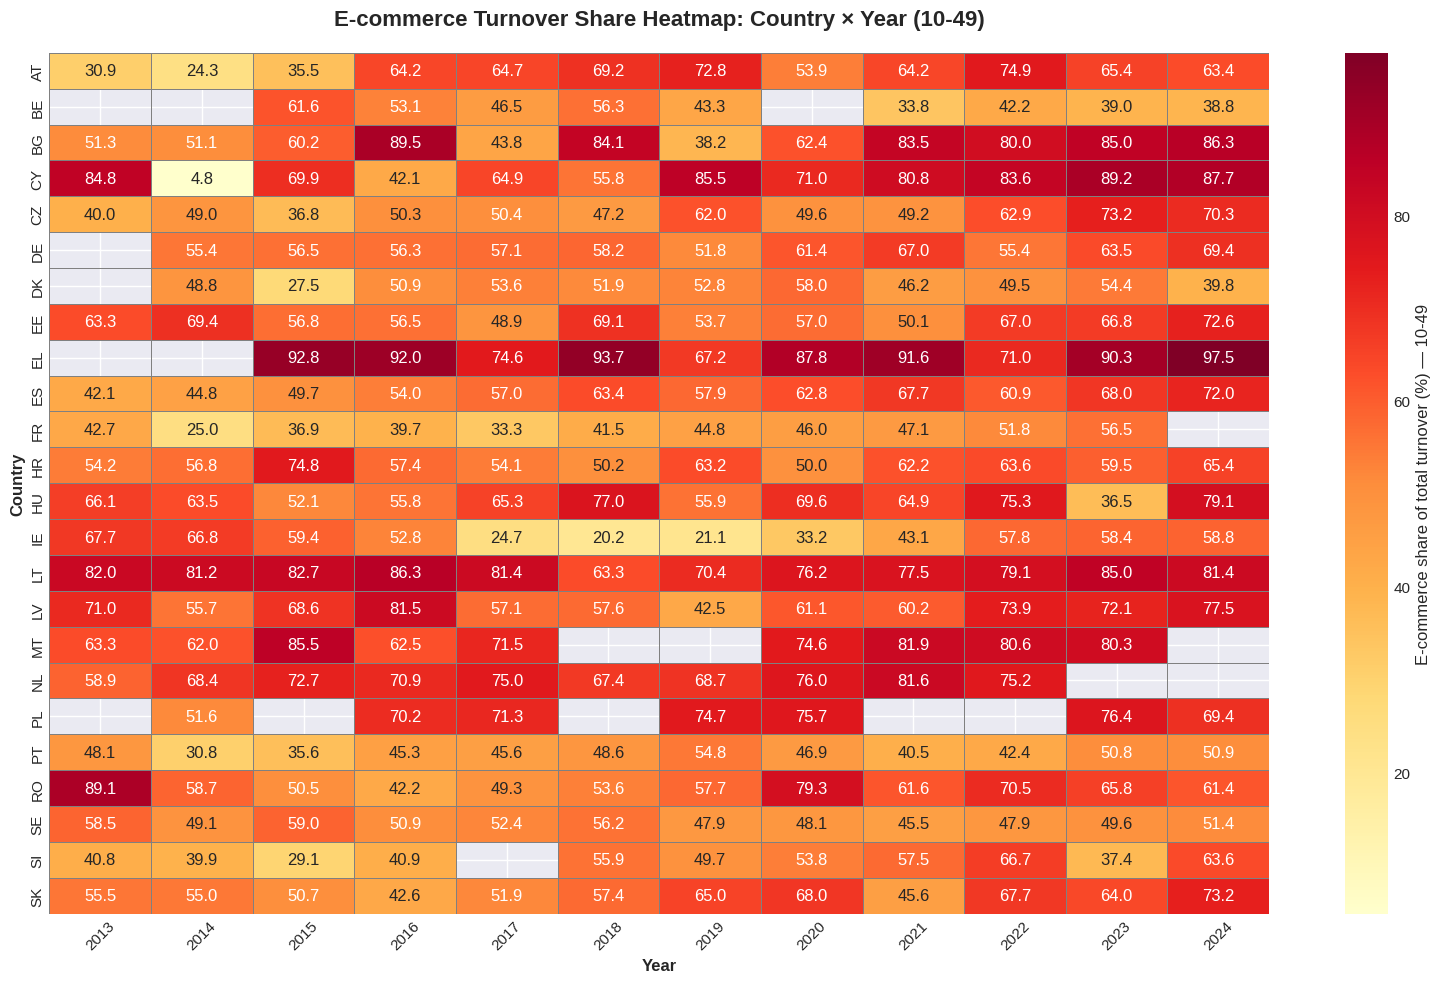

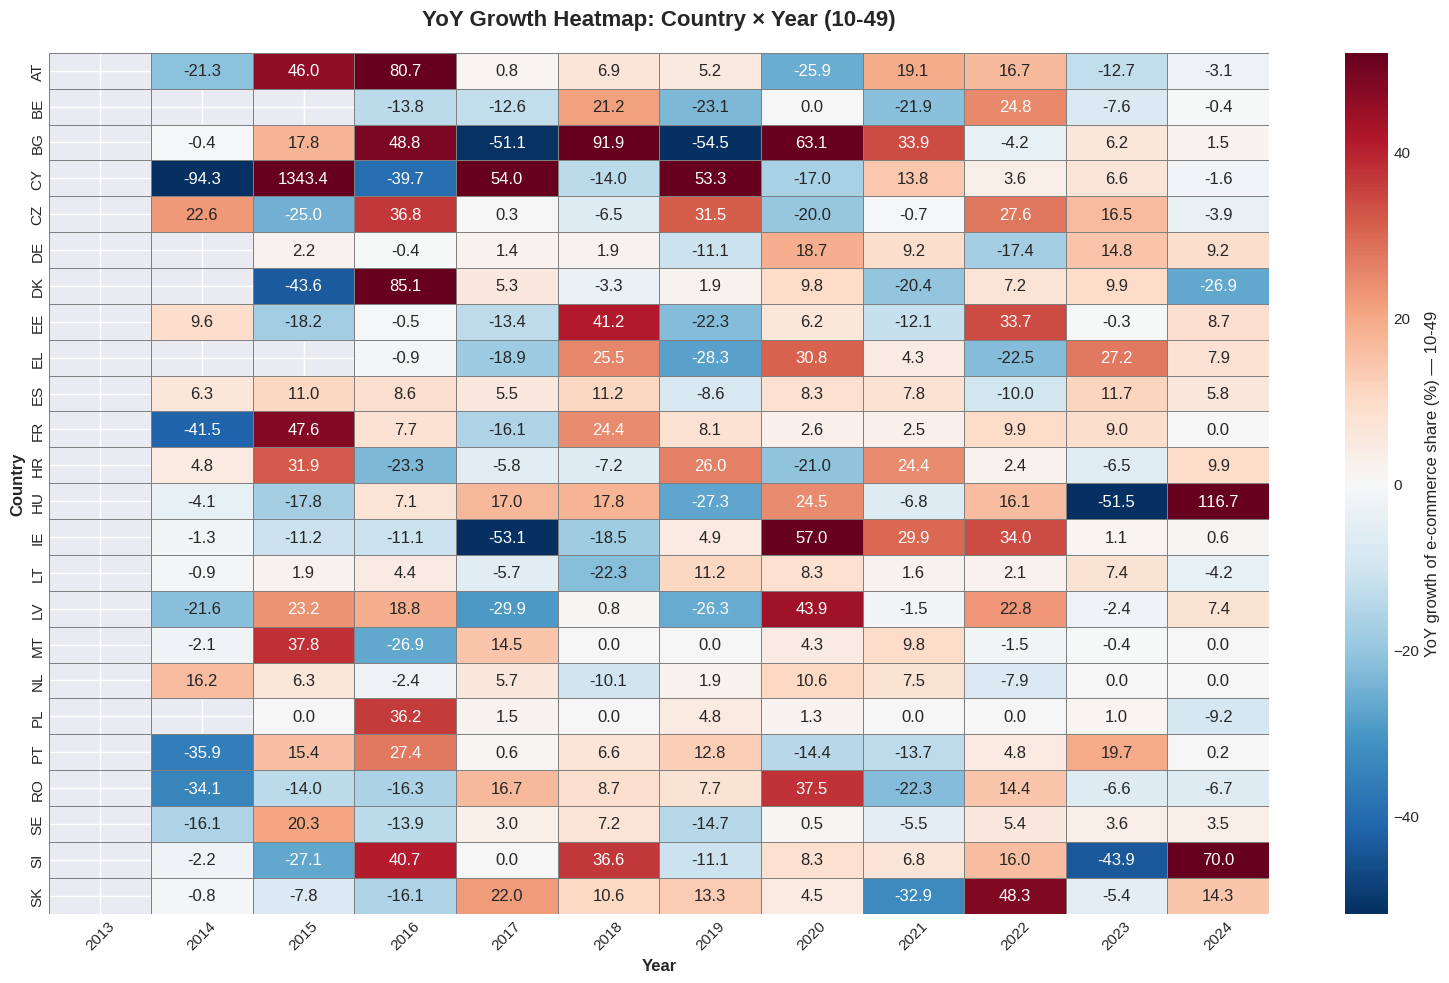

In [17]:
plt.style.use('seaborn-v0_8-darkgrid')

pivot_level = country_year.pivot(index="geo", columns="year", values="eturn_value")

plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_level,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": f"E-commerce share of total turnover (%) — {COMP_SIZE}"},
    linewidths=0.5,
    linecolor="gray"
)
plt.title(
    f"E-commerce Turnover Share Heatmap: Country × Year ({COMP_SIZE})",
    fontsize=16,
    fontweight="bold",
    pad=20
)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Country", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot_level = country_year.pivot(index="geo", columns="year", values="eturn_value").sort_index()

# YoY percent change (in % units)
pivot_yoy = pivot_level.pct_change(axis=1) * 100
mask = pivot_yoy.isna()

# Use 95th percentile of absolute YoY to avoid outliers dominating
v = np.nanpercentile(np.abs(pivot_yoy.values), 95)
v = max(v, 5)

plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_yoy,
    annot=True,
    fmt=".1f",
    cmap="RdBu_r",
    center=0,
    vmin=-v,
    vmax=v,
    mask=mask,
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": f"YoY growth of e-commerce share (%) — {COMP_SIZE}"}
)

plt.title(
    f"YoY Growth Heatmap: Country × Year ({COMP_SIZE})",
    fontsize=16,
    fontweight="bold",
    pad=20
)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Country", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Load EU geometries

In [18]:
growth_map_df["geo"] = (
    growth_map_df["geo"].astype(str).str.strip().str.upper().replace({"EL": "GR"})
)

eu_iso2_std = [c.strip().upper().replace("EL", "GR") for c in EU_ISO2]
eu_world = world[world["geo"].astype(str).str.strip().str.upper().isin(eu_iso2_std)].copy()
eu_geo = eu_world.merge(growth_map_df, how="left", on="geo")

eu_geo = eu_geo[
    eu_geo.geometry.representative_point().x.between(-25, 45) &
    eu_geo.geometry.representative_point().y.between(34, 72)
].copy()

eu_geo["geo"] = eu_geo["geo"].replace({"GR": "EL"})
eu_geo["geo_join"] = eu_geo["geo"].astype(str).replace({"EL": "GR"})
eu_geo["geo_label"] = eu_geo["geo"].astype(str).replace({"GR": "EL"})

### Turnover share and YoY growth choropletes

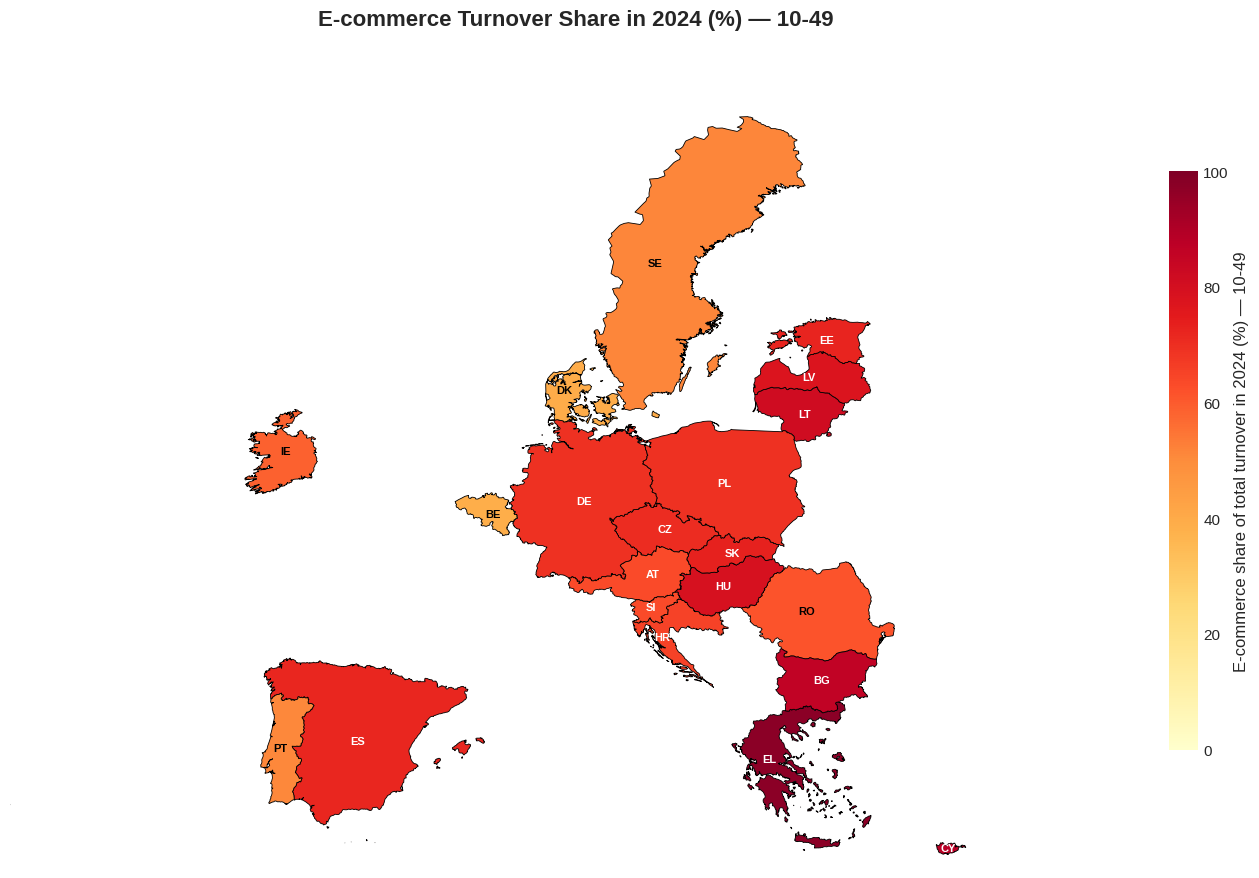

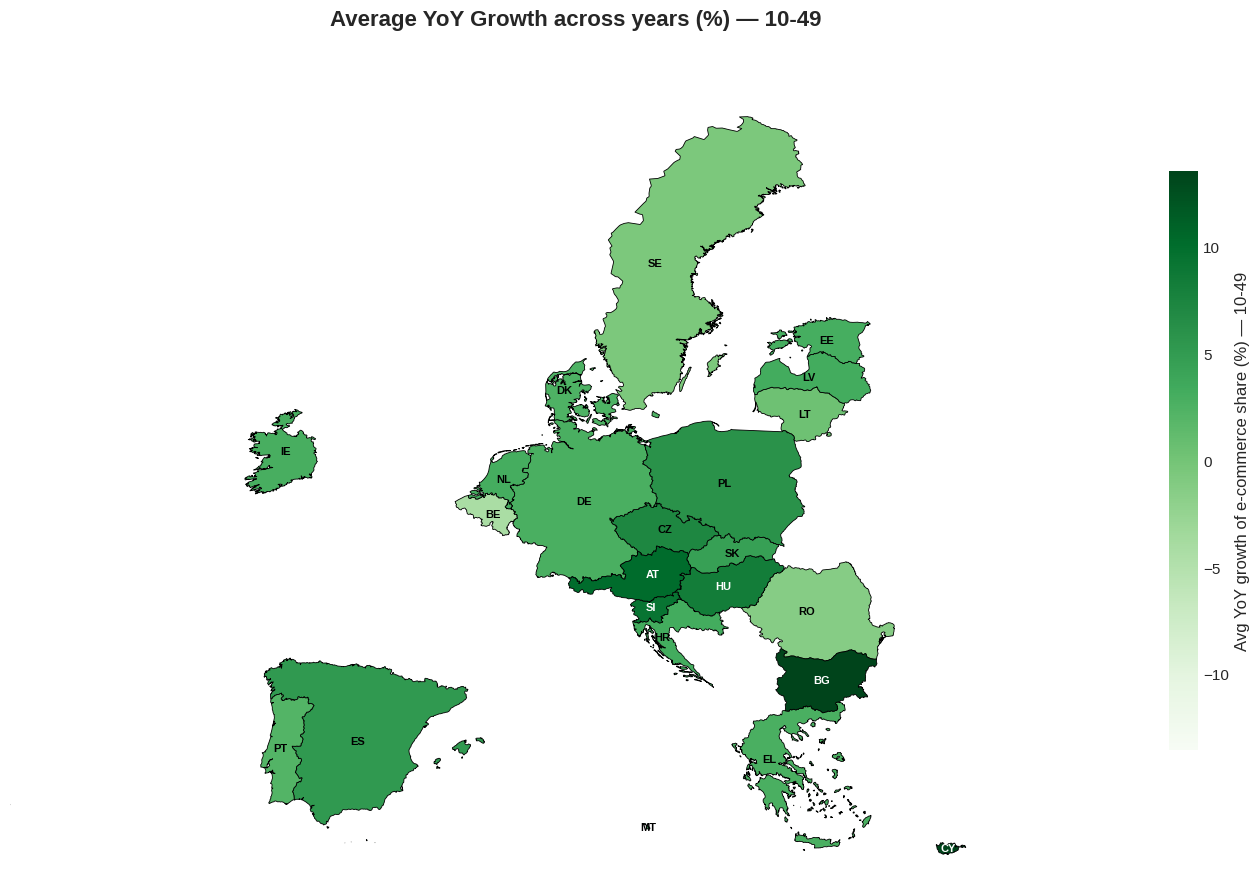

In [19]:
level_2024_tbl = (
    country_year
    .loc[(country_year["year"] == 2024)]
    .dropna(subset=["eturn_value"])
    .groupby("geo", as_index=False)["eturn_value"]
    .mean()
    .rename(columns={"eturn_value": "level_2024"})
)

level_2024_tbl["geo_join"] = level_2024_tbl["geo"].astype(str).replace({"EL": "GR"})

eu_geo_lvl = eu_geo.merge(
    level_2024_tbl[["geo_join", "level_2024"]],
    on="geo_join",
    how="left",
    validate="m:1"
)

vmin_lvl, vmax_lvl = 0, 100
cmap_lvl = plt.get_cmap("YlOrRd")
norm_lvl = mcolors.Normalize(vmin=vmin_lvl, vmax=vmax_lvl)

fig, ax = plt.subplots(figsize=(14, 10))
eu_geo_lvl.plot(
    column="level_2024",
    cmap="YlOrRd",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.6,
    vmin=vmin_lvl,
    vmax=vmax_lvl,
    legend_kwds={
        "shrink": 0.6,
        "aspect": 20,
        "pad": 0.02,
        "label": f"E-commerce share of total turnover in 2024 (%) — {COMP_SIZE}"
    }
)

ax.set_xlim(-25, 45)
ax.set_ylim(34, 72)

for _, row in eu_geo_lvl.iterrows():
    val = row["level_2024"]
    if pd.isna(val):
        continue

    geom = row["geometry"]
    x, y = geom.representative_point().coords[0]
    r, g, b, a = cmap_lvl(norm_lvl(val))
    brightness = 0.299*r + 0.587*g + 0.114*b
    text_color = "white" if brightness < 0.5 else "black"

    ax.text(
        x, y,
        row["geo_label"],
        ha="center", va="center",
        fontsize=8,
        fontweight="bold",
        color=text_color,
        zorder=5
    )

ax.set_title(
    f"E-commerce Turnover Share in 2024 (%) — {COMP_SIZE}",
    fontsize=16,
    fontweight="bold",
    pad=20
)
ax.axis("off")
plt.tight_layout()
plt.show()

avg_yoy_tbl = (
    country_year
    .dropna(subset=["eturn_yoy_growth"])
    .groupby("geo", as_index=False)["eturn_yoy_growth"]
    .mean()
    .rename(columns={"eturn_yoy_growth": "avg_yoy"})
)

avg_yoy_tbl["geo_join"] = avg_yoy_tbl["geo"].astype(str).replace({"EL": "GR"})

# Drop old columns
for col in ["avg_yoy", "avg_yoy_x", "avg_yoy_y"]:
    if col in eu_geo.columns:
        eu_geo = eu_geo.drop(columns=[col])

eu_geo_yoy = eu_geo.merge(
    avg_yoy_tbl[["geo_join", "avg_yoy"]],
    on="geo_join",
    how="left",
    validate="m:1"
)

vals = eu_geo_yoy["avg_yoy"].to_numpy(dtype=float)
vals = vals[~np.isnan(vals)]

lo, hi = np.percentile(vals, [5, 95])

v = max(abs(lo), abs(hi))
vmin_yoy, vmax_yoy = -v, v
cmap_yoy = plt.get_cmap("RdBu_r")
norm_yoy = mcolors.Normalize(vmin=vmin_yoy, vmax=vmax_yoy)

fig, ax = plt.subplots(figsize=(14, 10))
eu_geo_yoy.plot(
    column="avg_yoy",
    cmap="Greens",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.6,
    vmin=vmin_yoy,
    vmax=vmax_yoy,
    legend_kwds={
        "shrink": 0.6,
        "aspect": 20,
        "pad": 0.02,
        "label": f"Avg YoY growth of e-commerce share (%) — {COMP_SIZE}"
    }
)

ax.set_xlim(-25, 45)
ax.set_ylim(34, 72)

for _, row in eu_geo_yoy.iterrows():
    val = row["avg_yoy"]
    if pd.isna(val):
        continue

    geom = row["geometry"]
    try:
        x, y = geom.representative_point().coords[0]
    except Exception:
        x, y = geom.centroid.coords[0]

    r, g, b, a = cmap_yoy(norm_yoy(val))
    brightness = 0.299*r + 0.587*g + 0.114*b
    text_color = "white" if brightness < 0.5 else "black"

    ax.text(
        x, y,
        row["geo_label"],
        ha="center", va="center",
        fontsize=8,
        fontweight="bold",
        color=text_color,
        zorder=5
    )

ax.set_title(
    f"Average YoY Growth across years (%) — {COMP_SIZE}",
    fontsize=16,
    fontweight="bold",
    pad=20
)
ax.axis("off")
plt.tight_layout()
plt.show()


### Top 10 fastest growing countries - Bar chart and polar chart

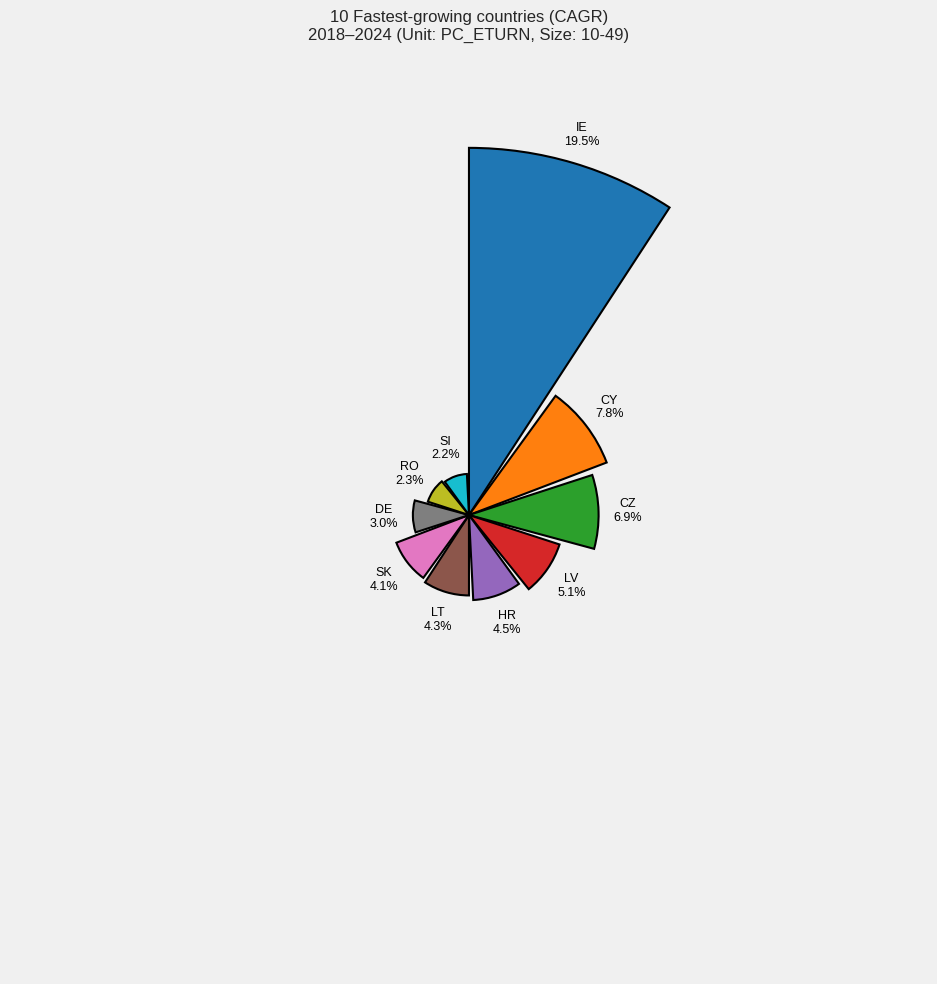

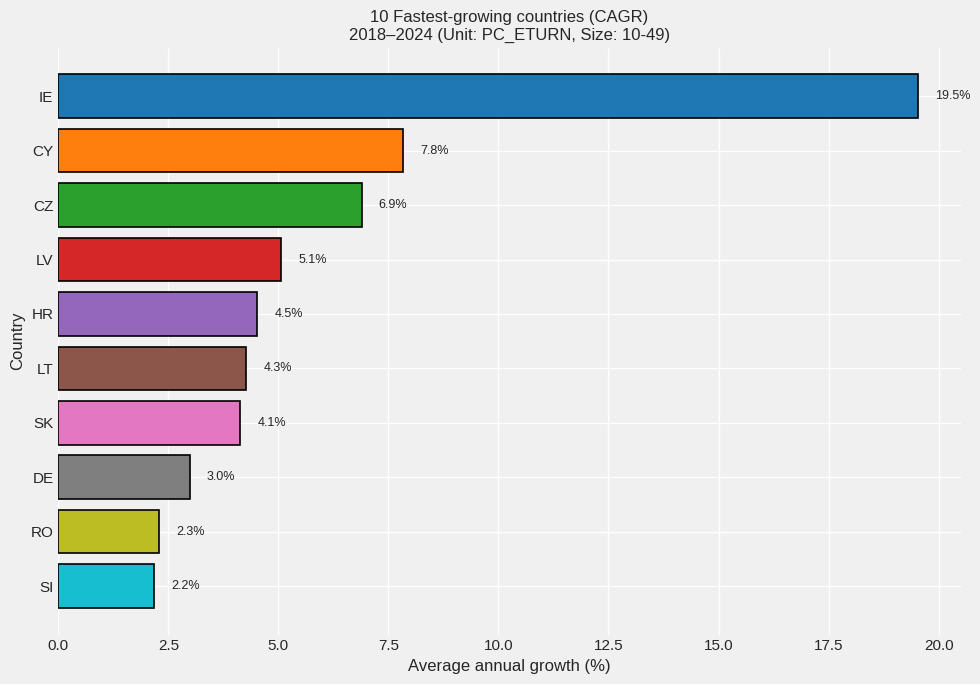

In [20]:
cy = country_year[country_year["year"].between(START_GROWTH_YEAR, latest_year)].copy()
wide = cy.pivot(index="year", columns="geo", values="eturn_value")
start_vals = wide.loc[START_GROWTH_YEAR]
end_vals = wide.loc[latest_year]

cagr_tbl = pd.DataFrame({
    "geo": start_vals.index.astype(str),
    "start_val": start_vals.values,
    "end_val": end_vals.values
}).dropna(subset=["start_val", "end_val"])


cagr_tbl = cagr_tbl[cagr_tbl["start_val"] > 0].copy()

n_years = latest_year - START_GROWTH_YEAR
cagr_tbl["cagr"] = ((cagr_tbl["end_val"] / cagr_tbl["start_val"]) ** (1 / n_years) - 1) * 100

df_top = (
    cagr_tbl
    .dropna(subset=["cagr"])
    .loc[cagr_tbl["cagr"] > 0, ["geo", "cagr"]]
    .sort_values("cagr", ascending=False)
    .head(TOP_K)
    .reset_index(drop=True)
)


top_countries = df_top["geo"].tolist()
cmap = get_cmap(cmap_name)
country_colors = {c: cmap(i % cmap.N) for i, c in enumerate(top_countries)}


def plot_fastest_growing_polar_cagr(
    df_top,
    title=None,
    country_colors=None,
):
    countries = df_top["geo"].to_numpy()
    values = df_top["cagr"].to_numpy(dtype=float)
    colors = [country_colors.get(c, "#333333") for c in countries]
    N = len(countries)
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    width = (2*np.pi / N) * 0.92

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    fig.patch.set_facecolor("#f0f0f0")
    ax.set_facecolor("#f0f0f0")

    ax.spines["polar"].set_visible(False)
    ax.grid(False)
    ax.set_theta_offset(np.pi / 2.0)
    ax.set_theta_direction(-1)

    ax.bar(
        theta,
        values,
        width=width,
        align="edge",
        color=colors,
        edgecolor="black",
        linewidth=1.5
    )

    ax.set_xticks(theta + width / 2)
    ax.set_xticklabels([])

    rmax = float(np.nanmax(values)) if np.nanmax(values) > 0 else 1.0

    for t, r, c in zip(theta, values, countries):
        ax.text(
            t + width / 2,
            r + rmax * 0.08,
            f"{c}\n{r:.1f}%",
            ha="center",
            va="center",
            fontsize=9,
            color="black"
        )

    title = f"{TOP_K} Fastest-growing countries (CAGR)\n{START_GROWTH_YEAR}–{latest_year} (Unit: {UNIT}, Size: {COMP_SIZE})"

    ax.set_title(title, pad=12)
    ax.set_ylim(0, rmax * 1.25)
    ax.set_yticks([])
    ax.grid(True, linewidth=0.6, alpha=0.05, linestyle="--")

    plt.tight_layout()
    plt.show()

plot_fastest_growing_polar_cagr(df_top=df_top, country_colors=country_colors)

bar = df_top.sort_values("cagr", ascending=True).copy()
colors_bar = [country_colors.get(c, "#333333") for c in bar["geo"]]

plt.figure(figsize=(10, 7))
ax = plt.gca()

plt.gcf().patch.set_facecolor("#f0f0f0")
ax.set_facecolor("#f0f0f0")
ax.grid(True, color="white", linewidth=1.0)
ax.set_axisbelow(True)

ax.barh(
    bar["geo"],
    bar["cagr"],
    color=colors_bar,
    edgecolor="black",
    linewidth=1.2
)

ax.set_title(
    f"{TOP_K} Fastest-growing countries (CAGR)\n{START_GROWTH_YEAR}–{latest_year} (Unit: {UNIT}, Size: {COMP_SIZE})"
)
ax.set_xlabel("Average annual growth (%)")
ax.set_ylabel("Country")

x_offset = bar["cagr"].max() * 0.02 if bar["cagr"].max() > 0 else 0.5
for i, v in enumerate(bar["cagr"]):
    ax.text(
        v + x_offset,
        i,
        f"{v:.1f}%",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()

### Q2: How has e-commerce adoption among firms with 10–49 employees evolved across European countries over the past decade?

#### Firms with 10-49 employees are a key driver of e-commerce adoption in Europe, as they tend to rely heavily on online sales to reach customers and scale their activities. Over the past decade, e-commerce adoption in this group has increased substantially across European countries. On average, these firms generated about 51\% of their turnover from e-commerce in the early period (2013--2016), rising to just over 60\% in the recent period (2020--2024), representing an increase of nearly 9 percentage points. By 2024, the average e-commerce share reached 59.6\%, with a median of 67.4\%, indicating that for many small firms online sales have become the dominant sales channel. However, adoption levels vary widely across countries. Greece, Cyprus, Bulgaria, Lithuania, and Hungary exhibit very high e-commerce reliance among small firms in 2024. Growth dynamics also differ markedly: since 2018, Ireland has recorded exceptionally fast growth, followed by Cyprus, Czechia, Latvia, and Croatia, suggesting rapid catch-up in several markets. Overall, the results point to a strong and sustained shift toward e-commerce among firms with 10--49 employees, driven by structural changes in technology and consumer behavior, but strongly influenced by national market conditions and reporting practices.

### Q4: What is the correlation between e-commerce adoption rates and revenue generation across different NACE sectors, and which sectors exhibit “High Adoption but Low Value” versus “Low Adoption but High Value”?

In [22]:
df.head()

,geo,geo_name,size_emp,size_label,indic_is,indic_label,unit,unit_label,year,value,nace_r2,nace_label
0,AT,Austria,GE250,Large (GE250),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2013,11.12,NaN,NaN
1,AT,Austria,GE250,Large (GE250),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2014,13.01,NaN,NaN
2,AT,Austria,GE250,Large (GE250),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2015,12.71,NaN,NaN
3,AT,Austria,GE250,Large (GE250),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2016,17.01,NaN,NaN
4,AT,Austria,GE250,Large (GE250),E_AWSVAL,Enterprises' turnover from web sales,PC_ETURN,Percentage of turnover from e-commerce sales,2017,15.14,NaN,NaN


In [23]:
"""
## Extract Key Metrics by Sector

### Metric 1: Adoption Rate
- **Indicator**: E_AESELL (Enterprises with e-commerce sales)
- **Unit**: PC_ENT (Percentage of enterprises)

### Metric 2: Revenue Generation
- **Indicator**: E_ETURN (Total e-commerce turnover)
- **Unit**: PC_TURN (Percentage of total turnover)
"""

# CODE CELL 4: Extract adoption rates (% enterprises with e-commerce)
adoption_data = df[
    (df['indic_is'] == 'E_AESELL') &
    (df['unit'] == 'PC_ENT')
].copy()

# Get latest year average by sector
latest_year = adoption_data['year'].max()
adoption_by_sector = adoption_data[
    adoption_data['year'] == latest_year
].groupby('nace_label')['value'].mean().reset_index()
adoption_by_sector = adoption_by_sector.rename(columns={'value': 'adoption_rate'})

print(f"✓ Adoption rates extracted for {latest_year}")
print(f"  Sectors: {len(adoption_by_sector)}")

# Extract revenue generation (% turnover from e-commerce)
revenue_data = df[
    (df['indic_is'] == 'E_ETURN') &
    (df['unit'] == 'PC_TURN')
].copy()

# Get latest year average by sector
revenue_by_sector = revenue_data[
    revenue_data['year'] == latest_year
].groupby('nace_label')['value'].mean().reset_index()
revenue_by_sector = revenue_by_sector.rename(columns={'value': 'revenue_pct'})

print(f"✓ Revenue data extracted for {latest_year}")
print(f"  Sectors: {len(revenue_by_sector)}")


✓ Adoption rates extracted for 2024
  Sectors: 7
✓ Revenue data extracted for 2024
  Sectors: 7


In [24]:
# Merge adoption and revenue data
sector_analysis = pd.merge(
    adoption_by_sector,
    revenue_by_sector,
    on='nace_label',
    how='inner'
)

# Shorten sector names for better visualization
sector_analysis['sector_short'] = sector_analysis['nace_label'].apply(
    lambda x: 'Accommodation & Food' if 'Accommodation' in x
    else 'Wholesale & Retail' if 'Wholesale' in x
    else 'Transport & Storage' if 'Transportation' in x
    else 'Info & Comm' if 'Information' in x
    else 'Admin & Support' if 'Administrative' in x
    else x
)

print("\n✓ Analysis dataset created")
print(f"  Sectors with both metrics: {len(sector_analysis)}")
print("\nDataset preview:")
display(sector_analysis)


✓ Analysis dataset created
  Sectors with both metrics: 7

Dataset preview:


,nace_label,adoption_rate,revenue_pct,sector_short
0,Accommodation and food service activities,42.912222,21.820000,Accommodation & Food
1,Administrative and support service activities,17.882222,17.425263,Admin & Support
2,Construction,9.000370,3.463684,Construction
3,Information and communication,27.685556,17.644500,Info & Comm
4,Manufacturing,24.724444,21.553500,Manufacturing
5,Transportation and storage,21.619630,20.547500,Transport & Storage
6,Wholesale and retail trade; repair of motor ve...,40.861852,18.869000,Wholesale & Retail


In [27]:
"""
## Correlation Analysis

Computing Pearson and Spearman correlation coefficients between adoption rate
and revenue generation.
"""

# CODE CELL 7: Calculate correlation
# Remove any NaN values
analysis_clean = sector_analysis.dropna(subset=['adoption_rate', 'revenue_pct'])

# Pearson correlation (linear relationship)
pearson_corr, pearson_p = pearsonr(
    analysis_clean['adoption_rate'],
    analysis_clean['revenue_pct']
)

# Spearman correlation (monotonic relationship)
spearman_corr, spearman_p = spearmanr(
    analysis_clean['adoption_rate'],
    analysis_clean['revenue_pct']
)

print("="*70)
print("CORRELATION ANALYSIS: Adoption Rate vs Revenue Generation")
print("="*70)
print(f"\n📊 Pearson Correlation:  {pearson_corr:.3f}")
print(f"   p-value: {pearson_p:.4f} {'(significant)' if pearson_p < 0.05 else '(not significant)'}")
print(f"\n📊 Spearman Correlation: {spearman_corr:.3f}")
print(f"   p-value: {spearman_p:.4f} {'(significant)' if spearman_p < 0.05 else '(not significant)'}")

# Interpretation
if abs(pearson_corr) > 0.7:
    strength = "strong"
elif abs(pearson_corr) > 0.4:
    strength = "moderate"
else:
    strength = "weak"

direction = "positive" if pearson_corr > 0 else "negative"

print(f"\n💡 Interpretation: {strength.capitalize()} {direction} correlation")
print("="*70)

CORRELATION ANALYSIS: Adoption Rate vs Revenue Generation

📊 Pearson Correlation:  0.679
   p-value: 0.0935 (not significant)

📊 Spearman Correlation: 0.714
   p-value: 0.0713 (not significant)

💡 Interpretation: Moderate positive correlation


In [28]:
"""
## Quadrant Classification

Classifying sectors into four quadrants based on median values:
- **High Adoption, High Value**: Leaders (successful e-commerce sectors)
- **High Adoption, Low Value**: High reach but low transaction value
- **Low Adoption, High Value**: Niche but valuable e-commerce
- **Low Adoption, Low Value**: E-commerce laggards
"""

# CODE CELL 8: Classify sectors into quadrants
# Calculate medians
median_adoption = analysis_clean['adoption_rate'].median()
median_revenue = analysis_clean['revenue_pct'].median()

# Classify quadrants
def classify_quadrant(row):
    if row['adoption_rate'] >= median_adoption and row['revenue_pct'] >= median_revenue:
        return 'High Adoption, High Value'
    elif row['adoption_rate'] >= median_adoption and row['revenue_pct'] < median_revenue:
        return 'High Adoption, Low Value'
    elif row['adoption_rate'] < median_adoption and row['revenue_pct'] >= median_revenue:
        return 'Low Adoption, High Value'
    else:
        return 'Low Adoption, Low Value'

analysis_clean['quadrant'] = analysis_clean.apply(classify_quadrant, axis=1)

# Print quadrant results
print("\n" + "="*70)
print("QUADRANT CLASSIFICATION")
print("="*70)
print(f"\nMedian Adoption Rate: {median_adoption:.1f}%")
print(f"Median Revenue %: {median_revenue:.1f}%")

for quadrant in ['High Adoption, High Value', 'High Adoption, Low Value',
                 'Low Adoption, High Value', 'Low Adoption, Low Value']:
    sectors = analysis_clean[analysis_clean['quadrant'] == quadrant]
    print(f"\n📌 {quadrant}:")
    if len(sectors) > 0:
        for idx, row in sectors.iterrows():
            print(f"   • {row['sector_short']}: "
                  f"Adoption={row['adoption_rate']:.1f}%, "
                  f"Revenue={row['revenue_pct']:.1f}%")
    else:
        print("   (No sectors in this quadrant)")



QUADRANT CLASSIFICATION

Median Adoption Rate: 24.7%
Median Revenue %: 18.9%

📌 High Adoption, High Value:
   • Accommodation & Food: Adoption=42.9%, Revenue=21.8%
   • Manufacturing: Adoption=24.7%, Revenue=21.6%
   • Wholesale & Retail: Adoption=40.9%, Revenue=18.9%

📌 High Adoption, Low Value:
   • Info & Comm: Adoption=27.7%, Revenue=17.6%

📌 Low Adoption, High Value:
   • Transport & Storage: Adoption=21.6%, Revenue=20.5%

📌 Low Adoption, Low Value:
   • Admin & Support: Adoption=17.9%, Revenue=17.4%
   • Construction: Adoption=9.0%, Revenue=3.5%


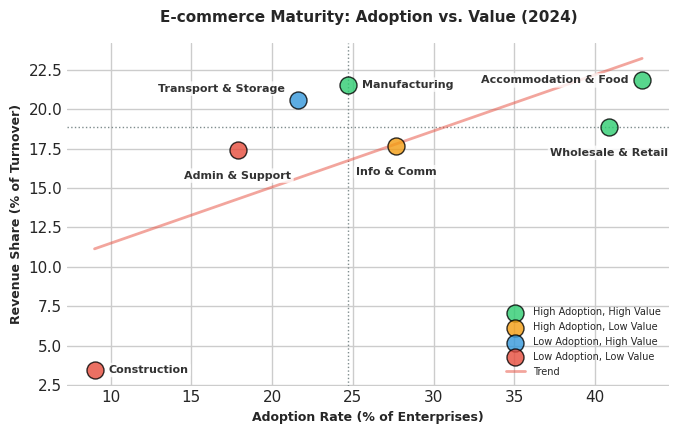

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Plotting Configuration
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(7, 4.5))

# Quadrant Colors
colors = {
    'High Adoption, High Value': '#2ecc71', # Green
    'High Adoption, Low Value': '#f39c12', # Orange
    'Low Adoption, High Value': '#3498db', # Blue
    'Low Adoption, Low Value': '#e74c3c'  # Red
}

# 2. Plot Scatter Points
for quadrant, color in colors.items():
    data = analysis_clean[analysis_clean['quadrant'] == quadrant]
    ax.scatter(data['adoption_rate'], data['revenue_pct'],
               s=150, alpha=0.8, c=color, label=quadrant,
               edgecolors='black', linewidth=1, zorder=3)

# 3. Custom Label Placement
# (X_Offset, Y_Offset) in points relative to the dot
custom_offsets = {
    'Transport & Storage': (-10, 5),    # Moved LEFT (< 0)
    'Manufacturing': (10, 0),           # Right
    'Accommodation & Food': (-10, 0),   # Left (keeps it in frame)
    'Wholesale & Retail': (0, -15),     # Down
    'Info & Comm': (0, -15),            # Down
    'Admin & Support': (0, -15),        # Down
    'Construction': (10, 0)             # Right
}

for idx, row in analysis_clean.iterrows():
    sector = row['sector_short']
    offset = custom_offsets.get(sector, (5, 5))

    # Dynamic Alignment Logic:
    # If we shift Left (negative X), align text to the 'right' so it ends at the dot.
    # If we shift Right (positive X), align text to the 'left' so it starts at the dot.
    x_off, y_off = offset
    ha = 'right' if x_off < 0 else 'left'
    if x_off == 0: ha = 'center'

    va = 'bottom' if y_off > 0 else 'top'
    if y_off == 0: va = 'center'

    ax.annotate(sector,
                (row['adoption_rate'], row['revenue_pct']),
                xytext=offset, textcoords='offset points',
                fontsize=8, fontweight='semibold', color='#333333',
                ha=ha, va=va, # Apply dynamic alignment
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8, ec='none'),
                zorder=5)

# 4. Add Median Lines
ax.axvline(median_adoption, color='#7f8c8d', linestyle=':', linewidth=1, zorder=1)
ax.axhline(median_revenue, color='#7f8c8d', linestyle=':', linewidth=1, zorder=1)

# 5. Add Trend Line
z = np.polyfit(analysis_clean['adoption_rate'], analysis_clean['revenue_pct'], 1)
p = np.poly1d(z)
x_line = np.linspace(analysis_clean['adoption_rate'].min(), analysis_clean['adoption_rate'].max(), 100)
ax.plot(x_line, p(x_line), color="#e74c3c", alpha=0.5, linewidth=2, label='Trend', zorder=2)

# 6. Formatting
ax.set_xlabel('Adoption Rate (% of Enterprises)', fontsize=9, fontweight='bold')
ax.set_ylabel('Revenue Share (% of Turnover)', fontsize=9, fontweight='bold')
ax.set_title('E-commerce Maturity: Adoption vs. Value (2024)', fontsize=11, fontweight='bold', pad=15)

# Clean up Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=7, framealpha=0.9, fancybox=True)

plt.tight_layout()
plt.show()

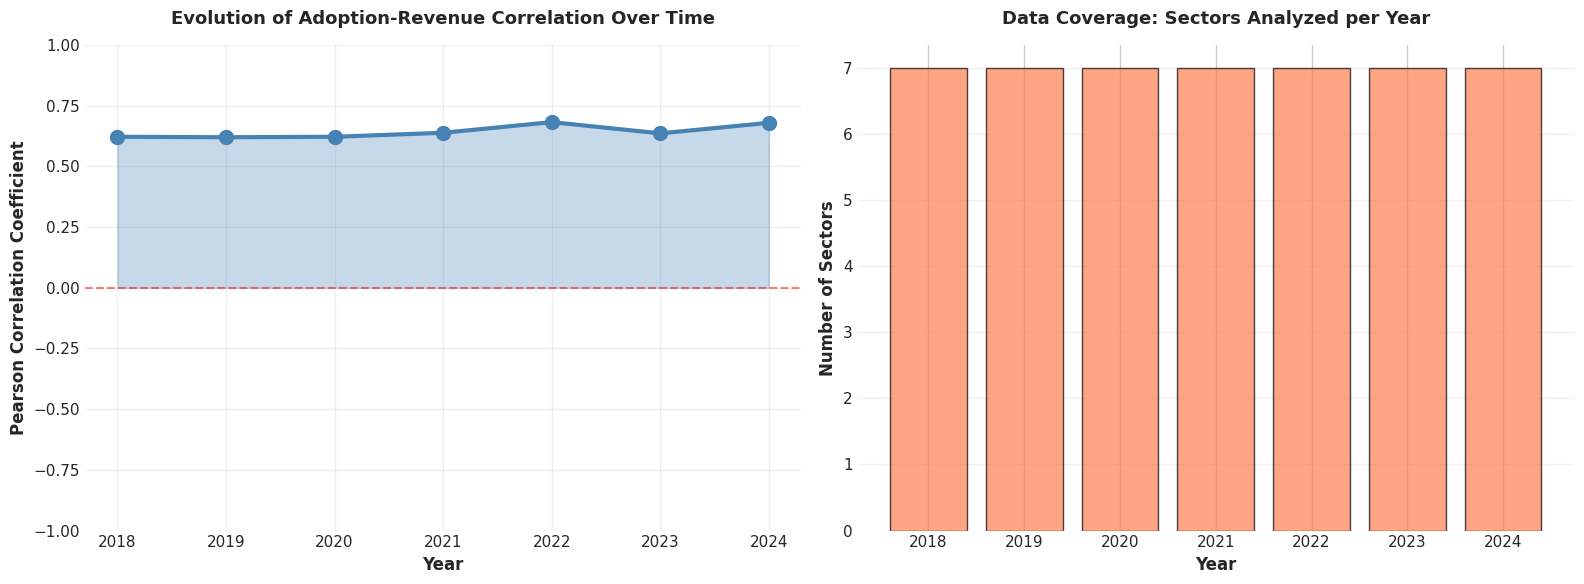


Correlation Trend Summary:


,year,correlation,p_value,n_sectors
0,2018,0.621456,0.136293,7
1,2019,0.619474,0.137916,7
2,2020,0.621465,0.136286,7
3,2021,0.637809,0.123276,7
4,2022,0.681765,0.091615,7
5,2023,0.635441,0.125120,7
6,2024,0.678916,0.093519,7


In [30]:
"""
Examining how the correlation has evolved over time (2018-2024).
"""

# CODE CELL 10: Correlation over time
years_to_analyze = range(2018, int(latest_year) + 1)
correlation_trends = []

for year in years_to_analyze:
    # Get data for this year
    adopt_year = adoption_data[adoption_data['year'] == year].groupby('nace_label')['value'].mean()
    revenue_year = revenue_data[revenue_data['year'] == year].groupby('nace_label')['value'].mean()

    # Merge
    year_df = pd.DataFrame({
        'adoption': adopt_year,
        'revenue': revenue_year
    }).dropna()

    if len(year_df) >= 3:  # Need at least 3 sectors for correlation
        corr, pval = pearsonr(year_df['adoption'], year_df['revenue'])
        correlation_trends.append({
            'year': year,
            'correlation': corr,
            'p_value': pval,
            'n_sectors': len(year_df)
        })

corr_df = pd.DataFrame(correlation_trends)

# Plot correlation trend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Correlation over time
ax1.plot(corr_df['year'], corr_df['correlation'],
         marker='o', linewidth=3, markersize=10, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.fill_between(corr_df['year'], 0, corr_df['correlation'], alpha=0.3, color='steelblue')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=12, fontweight='bold')
ax1.set_title('Evolution of Adoption-Revenue Correlation Over Time',
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1, 1)

# Right plot: Number of sectors analyzed
ax2.bar(corr_df['year'], corr_df['n_sectors'], color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Sectors', fontsize=12, fontweight='bold')
ax2.set_title('Data Coverage: Sectors Analyzed per Year',
              fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCorrelation Trend Summary:")
display(corr_df)

In [34]:
#  final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\n Correlation: {pearson_corr:.3f} ({strength} {direction}), p-val: {pearson_p}")
print(f" Trend: {'Strengthening' if corr_df.iloc[-1]['correlation'] > corr_df.iloc[0]['correlation'] else 'Weakening'} over time")
print(f" Key Insight: {analysis_clean[analysis_clean['quadrant'] == 'High Adoption, High Value']['sector_short'].tolist()}")
print("="*70)


FINAL SUMMARY

 Correlation: 0.679 (moderate positive), p-val: 0.09351889883267299
 Trend: Strengthening over time
 Key Insight: ['Accommodation & Food', 'Manufacturing', 'Wholesale & Retail']
